<a href="https://colab.research.google.com/github/pavanbaloju/agrivision-semantic-segmentation/blob/main/Unet_Exception_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !tar -xf drive/My\ Drive/Agriculture-Vision.tar

importing libraries

In [ ]:
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


defining datagenerators

In [ ]:
data_gen_args = dict(rescale = 1/255.,
                     rotation_range=90,
                     zoom_range=[0.5,1.0],
                     horizontal_flip = True,
                     vertical_flip = True,)
train_image_datagen = ImageDataGenerator(**data_gen_args, )
train_mask_datagen = ImageDataGenerator(**data_gen_args)
val_image_datagen = ImageDataGenerator(rescale = 1/255.)
val_mask_datagen = ImageDataGenerator(rescale = 1/255.)

loading data

In [ ]:
train_df = pd.read_csv("train_df.csv", index_col = [0])
val_df = pd.read_csv("val_df.csv", index_col=[0])
print(train_df.shape, val_df.shape)

(2338, 3) (1025, 3)


creating mask paths

In [ ]:
def func(f):
  return f[:-3]+"png"
train_mask_df = pd.DataFrame(train_df["image_name"].apply(func), columns=["image_name"])

In [ ]:
val_mask_df = pd.DataFrame(val_df["image_name"].apply(func), columns=["image_name"])

Creating train and mask generators of batchsize =8 and img_size = 256,256

In [ ]:
train_image_generator = train_image_datagen.flow_from_dataframe(
  train_df, directory = "Agriculture-Vision/train/images/rgb", x_col = "image_name", 
  batch_size = , seed = 42,class_mode = None
)
val_image_generator = val_image_datagen.flow_from_dataframe(
  val_df, directory = "Agriculture-Vision/val/images/rgb", x_col = "image_name", 
  batch_size = 16, seed = 42,class_mode = None
)
train_mask_generator = train_mask_datagen.flow_from_dataframe(
  train_mask_df, directory = "Agriculture-Vision/train/labels/weed_cluster", x_col = "image_name", 
  batch_size = 16, seed = 42, color_mode ="grayscale", class_mode = None
)
val_mask_generator = val_mask_datagen.flow_from_dataframe(
  val_mask_df, directory = "Agriculture-Vision/val/labels/weed_cluster", x_col = "image_name", 
  batch_size = 16, seed = 42, color_mode ="grayscale", class_mode = None
)

Found 2338 validated image filenames.
Found 1025 validated image filenames.
Found 2338 validated image filenames.
Found 1025 validated image filenames.


In [ ]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

In [ ]:
x = train_image_generator.next()
x.shape

(16, 256, 256, 3)

In [ ]:
y = train_mask_generator.next()
y.shape

(16, 256, 256, 1)

showing an image from trainset

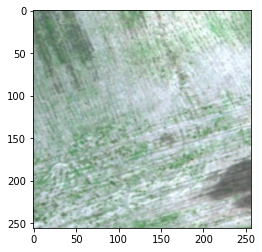

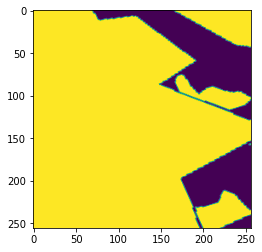

In [ ]:
index = np.random.randint(16)
plt.imshow(x[index,:,:,:])
plt.show()
plt.imshow(y[index,:,:,0])
plt.show()

Defining Unet-Xception Style model

In [ ]:
from keras import layers
input_shape = (256,256,3)
n_class = 1
def get_model(img_size=(128,128,1), n_classes=1):
    inputs = keras.Input(img_size)

    ### [First half of the network: downsampling inputs] ###


    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(rate = 0.2)(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Dropout(rate = 0.2)(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Dropout(rate = 0.2)(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Dropout(rate = 0.2)(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Dropout(rate = 0.2)(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(n_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(input_shape, n_class)


Defining Soft dice loss and callbacks

In [ ]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return 1 - K.mean((numerator + epsilon) / (denominator + epsilon))
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))

def scheduler(epoch, lr):
  if (epoch%5 !=0) | (epoch==0):
    return float(lr)
  else:
    return float(lr * 0.25)
losses = []
val_losses = []
mean_ious = []
val_mean_ious = []
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      losses.append(logs["loss"])
      val_losses.append(logs["val_loss"])
      mean_ious.append(logs["mean_iou"])
      val_mean_ious.append(logs["val_mean_iou"])

callback = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = "best_weights_of_unet_exceptio_dropout.hdf5",
    save_weights_only=True,
    monitor='mean_iou', 
    mode='max',
    save_best_only=True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-7)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', patience=5)



compiling model

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss = [soft_dice_loss], metrics= [mean_iou])

first training for 35 epochs with scheduler

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= 400, epochs = 35,validation_data=val_generator,
                    validation_steps = 80, initial_epoch = 0, callbacks=[checkpoint, callback])

plots of first training

In [ ]:
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('model mean_io_u')
plt.ylabel('mean_io_u')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])a
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def scheduler(epoch, lr):
  if epoch < 40:
    return 0.0005
  else:
    return float(lr * tf.math.exp(-0.1))

callback = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

extending training for 15 epochs

In [ ]:
history2 = model.fit_generator(train_generator, steps_per_epoch= 500, epochs = 50,validation_data=val_generator,
                    validation_steps = 158, initial_epoch = 35, callbacks=[checkpoint, callback])

In [ ]:
def scheduler(epoch, lr):
  if epoch%5==0:
    return float(lr*0.5)
  else:
    return float(lr)

callback2 = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

extending training for 30 epochs

In [ ]:
history3 = model.fit_generator(train_generator, steps_per_epoch= 500, epochs = 80,validation_data=val_generator,
                    validation_steps = 158, initial_epoch = 50, callbacks=[checkpoint, callback2])

In [ ]:
x = train_image_generator.next()
y = train_mask_generator.next()

In [ ]:
pred = (model.predict(x)>0.5).astype(int)

Plotting predictions vs true mask

In [ ]:
ind = 0
plt.imshow(pred[ind,:,:,0])
plt.show()
plt.imshow(y[ind,:,:,0])
plt.show()

In [ ]:
x = train_image_generator.next()
y = train_mask_generator.next()
preds = (model.predict(x)>0.5).astype(int)

In [ ]:
ind = 2
plt.imshow(preds[ind,:,:,0])
plt.show()
plt.imshow(y[ind,:,:,0])
plt.show()

In [ ]:
losses = []
val_losses = []
iou = []
val_iou = []
for his in [history, history2, history3]:
    losses = losses + his.history["loss"]
    val_losses = val_losses + his.history["val_loss"]
    iou = iou + his.history["mean_io_u"]
    val_iou = val_iou + his.history["val_mean_io_u"]

plotting overall training losses and mean ious

In [ ]:
plt.plot(iou)
plt.plot(val_iou)
plt.title('model mean_io_u')
plt.ylabel('mean_io_u')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(losses[:-1])
plt.plot(val_losses[:-1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
model.load_weights("best_weights_of_unet_exce.hdf5")

loss and mean_iou of train_set

In [ ]:
model.evaluate_generator(train_generator, steps = 8, verbose = 1)

loss and iou of val set

In [ ]:
model.evaluate_generator(val_generator, steps = 8, verbose = 1)

Predicting random test image

In [ ]:
import os
import cv2
test_paths = sorted(os.listdir("Agriculture-Vision/test/images/rgb"))
index = np.random.randint(len(test_paths))
img = cv2.resize(cv2.imread(os.path.join("Agriculture-Vision/test/images/rgb", test_paths[index])), (256,256))
print(img.shape)
plt.imshow(img)
plt.show()
img = np.expand_dims(np.array(img), axis = 0)
print(img.shape)
plt.imshow((model.predict(img/255.)>0.5).astype(int)[0,:,:,0], )
plt.show()
print(index)